---------------------------------------------
# <center>**Canny Edge Detection**<center>
---------------------------------------------

## Step 1: Grayscale Conversion

Import the image and convert to grayscale

In [1]:
import PIL
from PIL import Image

import numpy as np
import cv2

from scipy.ndimage.filters import convolve
from scipy import ndimage

import matplotlib.pyplot as plt

In [5]:
# import the image
imgPath = 'C:/Users/Rebecca/Documents/Virginia_Tech/SP22/Research/git-repos/hand-tremor-detection/hand-drawn-spiral-classifier-100patients/Spiral_DataSet1_relabelled/healthy/V01HE01.png'
img = PIL.Image.open(imgPath) # image shape is 256x256x3

# convert image to grayscale and resize to 128x128x1
img = img.convert("L") # convery to grayscale
img = np.array(img) / 255  # covert to pixel intensities matrix
img = cv2.resize(img, (128,128))  # resize to 128x128
# img = np.expand_dims(img, axis=2) # keep as grayscale by adding axis so shape is 128x128x1

## Step 2: Noise Reduction: Apply Gaussian Blur

Noise reduction helps to smooth over the image. It uses image convolution with a Gaussian Kernal of some arbitrary size (2k+1)x(2k+1).

As the kernal size increase, the more blur there is to the resulting image. Equation for a Guassian Filter Kernal is as follows:

$$
H_{ij} = \frac{1}{2 \pi \sigma^2} \exp(- \frac{(i - (k+1))^2 + (j-(k+1))^2}{2 \sigma^2}) ; 1 \leq i,j \leq (2k+1)
$$

In [6]:
# define a function to compute noise reduction
# function takes two inputs: k and value for sigma
# k is the value in the user-chosen (2k+1)x(2k+1) dimension
def gaussKernel(k, sigma=1):
    size = int(k) 
    x,y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2 * np.pi * sigma**2)
    H = normal * np.exp(-((x**2 + y**2) / (2 * sigma**2)))
    return H # return the gaussian kernal


## Step 3: Gradient Calculation
In this step, we detect the edge intensity and direction by calculating the gradient of the image. An edge is defined as any change between pixel intesities. We apply filters that highlight the intensity change in both the x (horizontal) and y (vertical) directions. 

Using the smoothed image (obtained from the the gaussian kernel convolution), the derivatives $\bf{Ix}$ and $\bf{Iy}$ can be calculated with respect to $\bf{x}$ and $\bf{y}$

Convole $\bf{I}$ with *Sorbel Kernals* $\bf{Kx}$ and $\bf{Ky}$:

$$
\bf{Ix} = \bf{Kx} * \bf{I} = 
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
* \bf{I}

\; \; , \; \;

\bf{Iy} = \bf{Ky} * \bf{I} =
\begin{bmatrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}
* \bf{I}
$$

Then calculate the gradient magnitude ($\bf{G}$) and slope ($\bf{\theta}$):

$$|\bf{G}| = \sqrt{\bf{Ix}^2 + \bf{Iy}^2}$$
$$\theta = \arctan{\bf{Iy} / \bf{Ix}}$$

In [7]:
# define a function to calculate the gradient 
# takes the smoothed image array as input

def gradCalc(img):
    # define sorbel kernels Kx and Ky
    Kx = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]], np.float32)

    # compute Ix and Iy by convolving the original image with Kx and Ky 
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    # compute the magnitude G, and slope theta
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return G, theta


## Step 4: Non-Maximum Suppression

Use non-maximum suppression (NMS) to thin out the edges. This algorithm goes through all points in the intensity matrix and finds the pixels with the maximum value in the edge direction.

NMS process: 
 - Create a zeros matrix of the same size as the original gradient intensity matrix
 - Identify the edge direction based on the angle value from the angle matrix
 - Check if the pixel in the same direction has a higher intensity than the pixel currently being processed
 - Return the image processed with the NMS algorithm

In [8]:
# define a function to perform NMS
# takes inputs: gradient intensity matrix, and theta matrix (outputs of gradCalc)

def NMS(gradIntensityMat, thetaMat):
    M, N = gradIntensityMat.shape
    Z = np.zeros((M,N), dtype=np.int32) # define zeros matrix
    angle = thetaMat * 180. / np.pi     # convert to degrees
    angle[angle < 0] += 180             # make all angles positive

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # angle 0
                if (0 <= angle[i,j] < 22.5) | (157.5 <= angle[i,j] <= 180):
                    q = gradIntensityMat[i, j+1]
                    r = gradIntensityMat[i, j-1]

                # angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = gradIntensityMat[i+1, j-1]
                    r = gradIntensityMat[i-1, j+1]

                # angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = gradIntensityMat[i+1, j]
                    r = gradIntensityMat[i-1, j]

                # angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = gradIntensityMat[i-1, j-1]
                    r = gradIntensityMat[i+1, j+1]

                if (gradIntensityMat[i,j] >= q) & (gradIntensityMat[i,j] >= r):
                    Z[i,j] = gradIntensityMat[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

## Step 5: Perform Double Thresholding

Identify strong, weak, and non-relevant pixels. 

- High threshold: identify strong pixels (intensity higher than high threshold)
- Low threshold: identify non-relevant pixels (intensity lower and low threshold)

Anything inbetween is considered a weak pixel.

In [9]:
# define a function to perform double thresholding
# takes as input the image returned from the NMS algorithm

def doubleThresholding(NMSimg, lowThresholdRatio, highThresholdRatio, weakVal, strongVal):
    highThresh = NMSimg.max() * highThresholdRatio
    lowThresh  = highThresh * lowThresholdRatio

    M,N = NMSimg.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(weakVal)
    strong = np.int32(strongVal)

    strong_i, strong_j = np.where(NMSimg >= highThresh)
    zeros_i, zeros_j = np.where(NMSimg < lowThresh)
    weak_i, weak_j = np.where((NMSimg <= highThresh) & (NMSimg >= lowThresh))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res

## Step 6: Edge Tracking by Hysteresis

Transform weak pixels into strong ones *iff* at least one of the pixels around the one being processed is a strong one

In [10]:
# define a function to perform edge tracking

def edgeTracking(threshImg, weakVal, strongVal):
    M,N = threshImg.shape
    weak = np.int32(weakVal)
    strong = np.int32(strongVal)

    for i in range(1,M-1):
        for j in range(1,N-1):
            if threshImg[i,j] == weak:
                try:
                    if ((threshImg[i+1, j-1] == strong) | (threshImg[i+1,j] == strong) | (threshImg[i+1, j+1] == strong) or \
                        (threshImg[i, j-1]   == strong) | (threshImg[i, j+1]   == strong) or \
                        (threshImg[i-1, j-1] == strong) | (threshImg[i-1,j] == strong) | (threshImg[i-1, j+1] == strong)):
                        threshImg[i,j] = strong
                    else:
                        threshImg[i,j]=0
                except IndexError as e:
                    pass

    return threshImg


## <center>Combine all steps to perform Edge Detection<center> 

In [22]:
# smooth out the image by convoling the original image with a guassian kernel
smoothedImg = convolve(img, gaussKernel(1, sigma=1)) # using a size 5x5 kernal with k=2

# perform the gradient calculation
gradMag, gradTheta = gradCalc(smoothedImg)

# perform non-maximum suppression
NMSimg = NMS(gradMag, gradTheta)

# perform double thresholding on the NMS image
thresthImg = doubleThresholding(NMSimg, lowThresholdRatio=0.1, highThresholdRatio=0.2, weakVal=100, strongVal=255)

# finally, compute the edge detection by hysteresis
finalImg = edgeTracking(thresthImg, weakVal=100, strongVal=255)

(-0.5, 127.5, 127.5, -0.5)

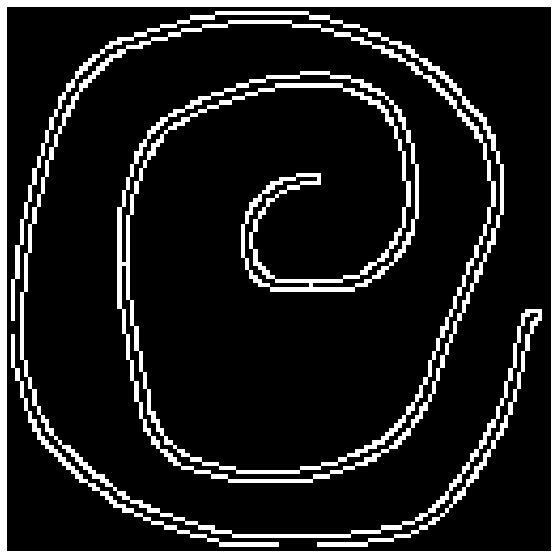

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(finalImg, cmap='gray')
ax.axis('off')
# plt.savefig('edgeSpiral', pad_inches=0, bbox_inches='tight')